In [2]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import logging
import numpy as np
from scipy.sparse import linalg as spla
import matplotlib.pyplot as plt
import logging
from mpl_toolkits import mplot3d
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import pickle as pkl
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

#add path to data folder
input_folder = "/Volumes/ExtDrive/data"
output_folder = "plots"
dpi=300

first_frame = 1
last_frame = 5000
Omega = 500

sphere_list = ['sphere115', 'sphere110', 'sphere118']

f1 = "%s/%s" % (input_folder, sphere_list[0])
f2 = "%s/%s" % (input_folder, sphere_list[1])
f3 = "%s/%s" %(input_folder, sphere_list[2])

fs = [f1, f2, f3]
#om_list = [np.zeros((last_frame-first_frame+1, 512, 256)) for i in range(3)]
#coeffs_list = [np.zeros((last_frame-first_frame+1, 256, 256), dtype=complex) for i in range(3)]
            

In [3]:
#get gammas from Lmid and kappa setting R=1 and tau=1
def get_gammas(Lmid, kappa):
    
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return [gamma0, gamma2, gamma4]

#define function that returns the neutral ell's for a given R/Lambda and kappa
def get_l(Lmid, kappa):
    
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    delta_p = (0.5/gamma4)*(-gamma2+np.sqrt(gamma2**2-4*gamma0*gamma4))
    delta_m = (0.5/gamma4)*(-gamma2-np.sqrt(gamma2**2-4*gamma0*gamma4))
    
    l_p = 0.5*(-1+np.sqrt(17+4*delta_p))
    l_m = 0.5*(-1+np.sqrt(17+4*delta_m))
        
    return l_m, l_p

def get_k(γ0, γ2, γ4):
    k_m = np.sqrt((-γ2 - np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    k_p = np.sqrt((-γ2 + np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    
    return k_m, k_p

def get_kmax(γ0, γ2, γ4):
    k_max = np.sqrt(-γ2/(2*γ4))
    
    return k_max
    


## Load the saved coefficients

In [4]:
ells = [get_l(2, 1), get_l(4, 1), get_l(8, 1)]
coeffs_list = [None for i in range(3)]

for i, str in enumerate(sphere_list):
    print(str)
    with open('../data/%s.pkl' %(sphere_list[i]), 'rb') as file:
        save_dict = pkl.load(file)
        t_arr = save_dict['t']
        coeffs_list[i] = save_dict['om_coeffs']
                
    

sphere115
sphere110
sphere118


### Find the phase speed by fitting a line to the phase 

In [5]:
L_max = 255
dt = t_arr[2] - t_arr[1]
phase_speed = np.zeros_like(coeffs_list[0])
phase = np.zeros_like(coeffs_list[0])
m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

Lmid_list = [2, 4, 8]
mean_phase_speed = [None for i in range(3)]

for i, str in enumerate(sphere_list):
    print(str)
    
    coeffs_all = coeffs_list[i]
    
    l_m, l_p = get_l(Lmid_list[i], 1)
    l_m = int(np.floor(l_m))
    l_p = int(np.ceil(l_p))

    for ind in range(len(t_arr)):
        if np.mod(ind+1,100)==0: print('Frame:%i'%(ind+1))
        if ind != len(t_arr)-1:
            coeffs_der = (coeffs_all[ind+1, :, :] - coeffs_all[ind, :, :])/dt
            Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind+1, :, :]))
        else: 
            coeffs_der = (coeffs_all[ind, :, :] - coeffs_all[ind-1, :, :])/dt
            Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind-1, :, :]))

        phase[ind, :, :] = np.angle(coeffs_all[ind,:,:])
        phase_speed[ind, :, :] = np.imag(np.conj(coeffs_all[ind,:,:])*coeffs_der/(Amp**2))/mm
        phase_speed[ind,:, l_p+1:] = np.nan
        phase_speed[ind,:, :l_m] = np.nan
        
    mean_phase_speed[i] = np.real(np.nanmean(phase_speed[1000:, :, :], axis=0))



sphere115


//anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Frame:100
Frame:200
Frame:300
Frame:400
Frame:500
Frame:600
Frame:700
Frame:800
Frame:900
Frame:1000
Frame:1100
Frame:1200
Frame:1300
Frame:1400
Frame:1500
Frame:1600
Frame:1700
Frame:1800
Frame:1900
Frame:2000
Frame:2100
Frame:2200
Frame:2300
Frame:2400
Frame:2500
Frame:2600
Frame:2700
Frame:2800
Frame:2900
Frame:3000
Frame:3100
Frame:3200
Frame:3300
Frame:3400
Frame:3500
Frame:3600
Frame:3700
Frame:3800
Frame:3900
Frame:4000
Frame:4100
Frame:4200
Frame:4300
Frame:4400
Frame:4500
Frame:4600
Frame:4700
Frame:4800
Frame:4900
Frame:5000


//anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


sphere110
Frame:100
Frame:200
Frame:300
Frame:400
Frame:500
Frame:600
Frame:700
Frame:800
Frame:900
Frame:1000
Frame:1100
Frame:1200
Frame:1300
Frame:1400
Frame:1500
Frame:1600
Frame:1700
Frame:1800
Frame:1900
Frame:2000
Frame:2100
Frame:2200
Frame:2300
Frame:2400
Frame:2500
Frame:2600
Frame:2700
Frame:2800
Frame:2900
Frame:3000
Frame:3100
Frame:3200
Frame:3300
Frame:3400
Frame:3500
Frame:3600
Frame:3700
Frame:3800
Frame:3900
Frame:4000
Frame:4100
Frame:4200
Frame:4300
Frame:4400
Frame:4500
Frame:4600
Frame:4700
Frame:4800
Frame:4900
Frame:5000
sphere118
Frame:100
Frame:200
Frame:300
Frame:400
Frame:500
Frame:600
Frame:700
Frame:800
Frame:900
Frame:1000
Frame:1100
Frame:1200
Frame:1300
Frame:1400
Frame:1500
Frame:1600
Frame:1700
Frame:1800
Frame:1900
Frame:2000
Frame:2100
Frame:2200
Frame:2300
Frame:2400
Frame:2500
Frame:2600
Frame:2700
Frame:2800
Frame:2900
Frame:3000
Frame:3100
Frame:3200
Frame:3300
Frame:3400
Frame:3500
Frame:3600
Frame:3700
Frame:3800
Frame:3900
Frame:4000
Frame:41

### Find the phase speed by FFT in time for each (m, ell) 

In [ ]:
L_max = 255
dt = t_arr[2] - t_arr[1]
#phase_speed = np.zeros_like(coeffs_list[0])
#phase = np.zeros_like(coeffs_list[0])
m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

Lmid_list = [2, 4, 8]
time_inds = np.arange(1000, 5000, 1)

window = np.hamming(len(time_inds)).reshape(len(time_inds),1,1)
dt = t_arr[2] - t_arr[1]

coeffs_fft = [None for i in range(3)]

for i, str in enumerate(sphere_list):
    print(str)
    
    coeffs_all = coeffs_list[i]
    
    l_m, l_p = get_l(Lmid_list[i], 1)
    l_m = int(np.floor(l_m))
    l_p = int(np.ceil(l_p))

    coeffs_fft[i] = np.fft.fft(coeffs_all[time_inds, :, :]*window, axis=0)
    coeffs_fft[i] = np.fft.fftshift(coeffs_fft[i], axes=0)

    
#time freq is taken to be negative to be consistent with the waves definition
time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
        



In [ ]:
from scipy.signal import find_peaks, find_peaks_cwt, medfilt
sig = np.log10(np.abs(coeffs_fft[2][:, 20, 20]))
plt.plot(time_freq, sig, '.', markersize=1)
plt.plot(time_freq, medfilt(sig, 41))

In [ ]:
from scipy.signal import find_peaks, find_peaks_cwt, medfilt

#Do median filtering and find the phase speed 
mean_phase_speed = [np.empty_like(coeffs_all[0,:,:])*np.nan for i in range(3)]

for i in range(3):
    print(i)
    l_m, l_p = get_l(Lmid_list[i], 1)
    l_m = int(np.floor(l_m))
    l_p = int(np.ceil(l_p))
    
    for ell in range(l_m, l_p+1):
        for m in range(1, ell+1):
            sig = np.log10(np.abs(coeffs_fft[i][:, m, ell]))
            max_ind = np.argmax(medfilt(sig, 41))
            mean_phase_speed[i][m,ell] = -time_freq[max_ind]/m
    


In [ ]:
import matplotlib as mpl
fm = mpl.font_manager
fm.get_cachedir()

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)

fig = plt.figure(figsize=(6,2))

for i in range(3):
    l_m, l_p = get_l(Lmid_list[i], 1)
    l_m = int(np.floor(l_m))
    l_p = int(np.ceil(l_p))
    
    plt.subplot(1, 3, i+1)
    img = plt.pcolormesh(mm, ellell, np.real(mean_phase_speed[i])*ellell*(ellell+1)/(2*Omega),\
                         vmin=0, vmax=2, cmap='jet', rasterized=True)
    plt.xlim([0,l_p+1]); plt.ylim([l_m-1,l_p+1])
    #plt.colorbar(); plt.title(r'$-\ell (\ell +1) \langle c_p^\phi \rangle_t/(2 \Omega)$', usetex=True)
    plt.xlabel(r'$m$', usetex=True); plt.ylabel(r'$\ell$', usetex=True, rotation=0, labelpad=5)
    plt.title(r'$\frac{R}{\Lambda} = %i$' %(Lmid_list[i]))
    
fig.subplots_adjust(right=0.8)
cbaxes = fig.add_axes([0.99, 0.3, 0.01, 0.5])
cb = fig.colorbar(img, cax = cbaxes)
cb.ax.set_ylabel(r'$-\ell (\ell +1) \langle c_p^\phi \rangle_t/(2 \Omega)$', rotation=270, labelpad=15)
plt.tight_layout()

plt.savefig('../plots/sphere_modes.pdf', bbox_inches='tight', dpi=300)

//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


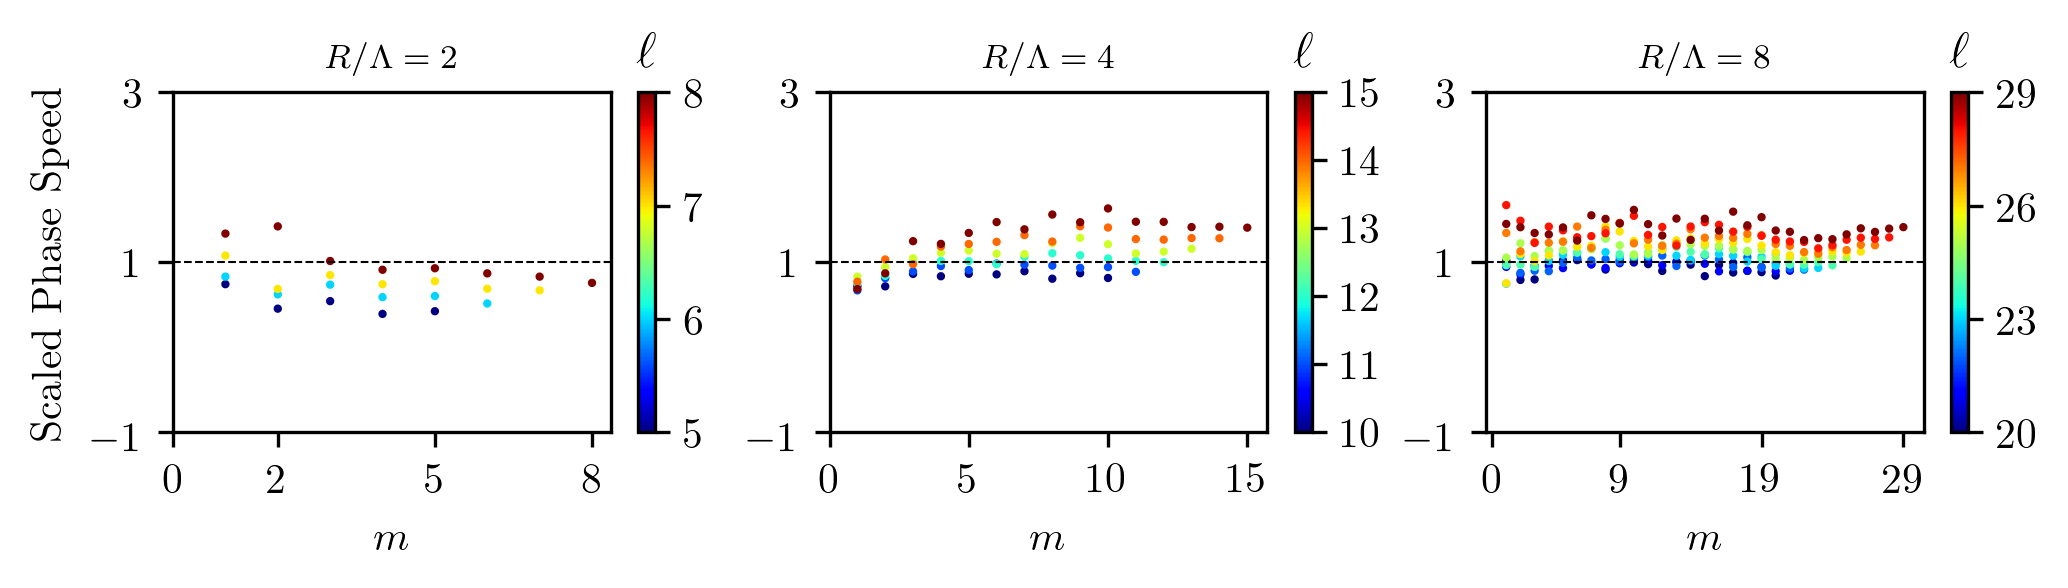

In [60]:
fig = plt.figure(figsize=(8,1.5), dpi=300)
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size': 10})

for i in range(3):
    l_m, l_p = get_l(Lmid_list[i], 1)
    l_m = int(np.floor(l_m))
    l_p = int(np.ceil(l_p))
    
    plt.subplot(1, 3, i+1)
    for ell in range(l_m, l_p+1):
        #print(mean_phase_speed[i][1:ell+1, ell]*ell*(ell+1)/(2*Omega))
        img=plt.scatter(np.arange(1, ell+1), mean_phase_speed[i][1:ell+1, ell]*ell*(ell+1)/(2*Omega), s=4, \
                 c=ell*np.ones(ell), marker='.', vmin=l_m, vmax=l_p, cmap='jet')
        
    cb = plt.colorbar()
    cb.ax.set_title(r'$\ell$')
    cb.set_ticks(np.arange(l_m, l_p+1, int((l_p-l_m)/3)))
    
    plt.axhline(1, linestyle='--', color='k', linewidth=0.5)
    #plt.legend(np.arange(l_m, l_p+1))
    plt.ylim([-1, 3]); plt.yticks([-1, 1, 3])
    plt.xlabel(r'$m$', usetex=True); 
    plt.title(r'$R/\Lambda = %i$' %(Lmid_list[i]), fontsize=8)
    plt.xticks(np.linspace(0, l_p, 4, dtype=int))
    
    if i==0:
        plt.ylabel(r'Scaled Phase Speed', usetex=True, labelpad=5)

#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.99, 0.3, 0.01, 0.5])
#cb = fig.colorbar(img, cax = cbaxes)
#cb.ax.set_ylabel(r'$\ell$', rotation=0)
#plt.tight_layout()
plt.savefig('../plots/figure3_sphere_disp.pdf', bbox_inches='tight')


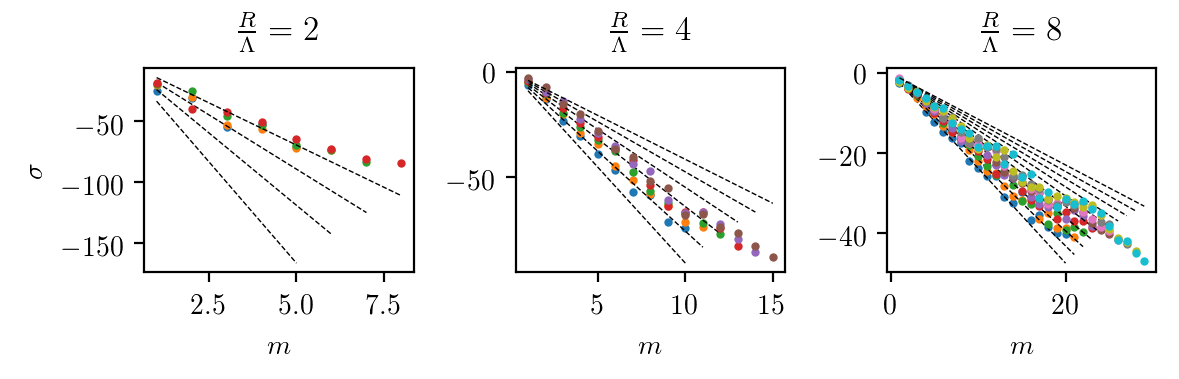

In [19]:
from matplotlib import rc
fig = plt.figure(figsize=(6,2), dpi=200)


for i in range(3):
    l_m, l_p = get_l(Lmid_list[i], 1)
    l_m = int(np.floor(l_m))
    l_p = int(np.ceil(l_p))
    
    plt.subplot(1, 3, i+1)
    for ell in range(l_m, l_p+1):
        #print(mean_phase_speed[i][1:ell+1, ell]*ell*(ell+1)/(2*Omega))
        m = np.arange(1, ell+1)
        sigma = mean_phase_speed[i][m, ell]*m
        plt.plot(m, -sigma, '.', markersize=4)
        plt.plot(m, -m*(2*Omega)/(ell*(ell+1)), 'k--', linewidth=0.5)
    
    #plt.legend(np.arange(l_m, l_p+1))
    #plt.ylim([0, 2])
    plt.xlabel(r'$m$', usetex=True); 
    plt.title(r'$\frac{R}{\Lambda} = %i$' %(Lmid_list[i]))
    
    if i==0:
        plt.ylabel(r'$\sigma$', usetex=True, labelpad=5)

plt.tight_layout()

In [ ]:
l_m, l_p = get_l(Lmid_list[0], 1)
l_m = int(np.floor(l_m))
l_p = int(np.ceil(l_p))

In [ ]:
(l_p-l_m)/4

In [ ]:
matplotlib.font_manager.get_cachedir()

In [ ]:
from matplotlib import font_manager
font_manager.findfont('DejaVu Sans')

In [ ]:
from matplotlib.font_manager import _rebuild; _rebuild()


In [8]:
from matplotlib.font_manager import OSXInstalledFonts; print(OSXInstalledFonts())

['/Library/Fonts/Andale Mono.ttf', '/Library/Fonts/Apple Chancery.ttf', '/Library/Fonts/AppleGothic.ttf', '/Library/Fonts/AppleMyungjo.ttf', '/Library/Fonts/Arial Black.ttf', '/Library/Fonts/Arial Bold Italic.ttf', '/Library/Fonts/Arial Bold.ttf', '/Library/Fonts/Arial Italic.ttf', '/Library/Fonts/Arial Narrow Bold Italic.ttf', '/Library/Fonts/Arial Narrow Bold.ttf', '/Library/Fonts/Arial Narrow Italic.ttf', '/Library/Fonts/Arial Narrow.ttf', '/Library/Fonts/Arial Rounded Bold.ttf', '/Library/Fonts/Arial Unicode.ttf', '/Library/Fonts/Arial.ttf', '/Library/Fonts/Ayuthaya.ttf', '/Library/Fonts/BigCaslon.ttf', '/Library/Fonts/Bodoni 72 Smallcaps Book.ttf', '/Library/Fonts/Bodoni Ornaments.ttf', '/Library/Fonts/Bradley Hand Bold.ttf', '/Library/Fonts/Brush Script.ttf', '/Library/Fonts/Chalkduster.ttf', '/Library/Fonts/cmunbl.ttf', '/Library/Fonts/cmunbtl.ttf', '/Library/Fonts/cmunbto.ttf', '/Library/Fonts/cmunci.ttf', '/Library/Fonts/cmunit.ttf', '/Library/Fonts/cmunobi.ttf', '/Library/Fon

In [12]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/Library/Fonts/Microsoft/MS Reference Specialty.ttf',
 '/System/Library/Fonts/SFNSDisplayCondensed-Semibold.otf',
 '/Library/Fonts/Microsoft/Consolas Bold.ttf',
 '/usr/X11R6/lib/X11/fonts/TTF/VeraIt.ttf',
 '/usr/X11/lib/X11/fonts/OTF/GohaTibebZemen.otf',
 '/usr/X11/lib/X11/fonts/OTF/SyrCOMKharput.otf',
 '/System/Library/Fonts/SFCompactText-SemiboldItalic.otf',
 '/usr/X11R6/lib/X11/fonts/TTF/luxisr.ttf',
 '/usr/X11/lib/X11/fonts/TTF/luxirb.ttf',
 '/Library/Fonts/STIXSizThreeSymBol.otf',
 '/Library/Fonts/DIN Condensed Bold.ttf',
 '/Library/Fonts/Microsoft/Lucida Sans Unicode.ttf',
 '/Library/Fonts/Microsoft/monbaiti.ttf',
 '/Users/Rohit/Library/Fonts/cmunit.ttf',
 '/Library/Fonts/STIXIntDBol.otf',
 '/Users/Rohit/Library/Fonts/cmunbto.ttf',
 '/Library/Fonts/Diwan Thuluth.ttf',
 '/Library/Fonts/BigCaslon.ttf',
 '/Library/Fonts/Courier New Italic.ttf',
 '/Library/Fonts/Microsoft/Perpetua Bold Italic.ttf',
 '/usr/X11/lib/X11/fonts/TTF/GohaTibebZemen.ttf',
 '/Library/Fonts/Microsoft/MS Refe